In [505]:
import os
import datetime as dt

#=====RUN NAME INPUT=====#
runName = "Run0003" # Folder name in Runs
crmRunName = "Data0.csv" # File name of clean room monitoring system (crm)
dcRunName = "dc.csv" # File name of dust counter (dc) run
#========================#
binSize = 3 * 60 # seconds per bin
binStart = dt.datetime( 2021, 12, 8, 15, 14, 0 ) # 2021-12-06 14:16:00.000000
binStop = dt.datetime( 2021, 12, 13, 13, 30, 0 ) # 2021-12-06 14:16:00.000000
#========================#

os.chdir( "/Users/noaheverett/Documents/Codes/MyRepos/crm/Analysis/Runs/" + runName )

print( "Run Folder:", runName )
print( "Clean Room Monitoring Run Name:", crmRunName )
print( "Dust Counter Run Name", dcRunName )
print( "Run Path:", os.getcwd() )
print( "Clean Room Monitoring Run Path:", str( os.getcwd() ) + "/" + crmRunName )
print( "Dust Counter Run Path:", str( os.getcwd() ) + "/" + dcRunName )

Run Folder: Run0003
Clean Room Monitoring Run Name: Data0.csv
Dust Counter Run Name dc.csv
Run Path: /Users/noaheverett/Documents/Codes/MyRepos/crm/Analysis/Runs/Run0003
Clean Room Monitoring Run Path: /Users/noaheverett/Documents/Codes/MyRepos/crm/Analysis/Runs/Run0003/Data0.csv
Dust Counter Run Path: /Users/noaheverett/Documents/Codes/MyRepos/crm/Analysis/Runs/Run0003/dc.csv


In [506]:
import pandas as pd

def reformat( data_pd ):
    data_list = [ [ column for column in data_pd ] ]
    for nRow in range( len( data_pd[ "Date Time" ] ) ):
        if data_pd[ "Date Time" ][ nRow ] >= binStart.timestamp() and data_pd[ "Date Time" ][ nRow ] < binStop.timestamp():
            data_list.append( [ data_pd[ column ][ nRow ] for column in data_pd ] )

    return data_list

def rebin( data ):
    data_rb = [ [ column for column in data[ 0 ] ] + [ "nDataPoints" ] ]
    nBin = 0
    nData = 0
    row = [ 0 for column in data_rb[ 0 ] ]
    for nRow in range( 1, len( data ) ):
        if data[ nRow ][ 0 ] - binStart.timestamp() >= ( nBin + 1 ) * binSize: 
            row[ 0 ] = nBin * binSize + binStart.timestamp()
            row[ -1 ] = nData
            if nData == 0:
                sys.exit( "Rows before row " + str( nRow ) + " have skip in Date Time" )
            for column in range( len( row ) ): 
                if column != 0 and column != len( row ) - 1:
                    row[ column ] /= nData
            data_rb.append( [ row[ nColumn ] for nColumn in range( len( row ) ) ] )
            
            for nColumn in range( len( row ) ): 
                row[ nColumn ] = 0
            nData = 0

            nBin += 1

        for nColumn in range( 1, len( row[ :-1 ] ) ): 
            row[ nColumn ] += data[ nRow ][ nColumn ]
        nData += 1
    
    return data_rb

In [507]:
import sys

crm = pd.read_csv( str( os.getcwd() ) + "/" + crmRunName, header = 0, index_col = False )
dc = pd.read_csv( str( os.getcwd() ) + "/" + dcRunName, header = 0, names = [ "Date Time", "Dust_Small", "Dust_Large" ], index_col = False, skiprows = 7 )

crm = crm.drop( columns = [ "Actual Time", "Run Time", "Temperature_MS8607", 
                            "Temperature_DHT22", "Humidity_MS8607", "Humidity_DHT22", 
                            "Pressure", "VolatileOrganicCompounds_eCO2", "VolatileOrganicCompounds_TVOC" ] )

crm[ "Date Time" ] = [ dt.datetime.strptime( time, "%Y-%m-%d %H:%M:%S.%f" ).timestamp() for time in crm[ "Date Time" ] ]
dc[ "Date Time" ] = [ dt.datetime.strptime( time, "%m/%d/%y %H:%M" ).timestamp() for time in dc[ "Date Time" ] ]

print( "Length of Clean Room Monitoring System Data File:", len( crm ) )
print( "Length of Dylos Data File:", len( dc ) )

crm = reformat( crm )
dc = reformat( dc )

print( "Length of Usable Clean Room Monitoring System Data:", len( crm ) )
print( "Length of Usable Dylos Data:", len( dc ) )

crm = rebin( crm )
dc = rebin( dc )

print( "Length of Rebinned Clean Room Monitoring System Data:", len( crm ) )
print( "Length of Rebinned Dylos Data:", len( dc ) )

if( len( crm ) != len( dc ) ):
    sys.exit( "Rebinning Failed. len(crm) != len(dc)" )

for nRow in range( 1, len( crm ) ):
    crm[ nRow ][ 0 ] = dt.datetime.fromtimestamp( crm[ nRow ][ 0 ] )
for nRow in range( 1, len( dc ) ):
    dc[ nRow ][ 0 ] = dt.datetime.fromtimestamp( dc[ nRow ][ 0 ] )

for nRow in range( 1, len( crm ) ):
    for nColumn in range( 1, len( crm[ 0 ][ :-1 ] ) ):
        crm[ nRow ][ nColumn ] *= 10
for nRow in range( 1, len( dc ) ):
    for nColumn in range( 1, len( dc[ 0 ][ :-1 ] ) ):
        dc[ nRow ][ nColumn ] *= 0.0353147

print( "crm columns:", crm[ 0 ] )
print( "dc columns:", dc[ 0 ] )

Length of Clean Room Monitoring System Data File: 141227
Length of Dylos Data File: 7415
Length of Usable Clean Room Monitoring System Data: 67844
Length of Usable Dylos Data: 7233
Length of Rebinned Clean Room Monitoring System Data: 2366
Length of Rebinned Dylos Data: 2366
crm columns: ['Date Time', 'Dust_PM10Standard', 'Dust_PM25Standard', 'Dust_PM100Standard', 'Dust_PM10Env', ' Dust_PM25Env', 'Dust_PM100Env', 'Dust_Particles03um', 'Dust_Particles05um', 'Dust_Particles10um', 'Dust_Particles25um', 'Dust_Particles50um', 'Dust_Particles100', 'nDataPoints']
dc columns: ['Date Time', 'Dust_Small', 'Dust_Large', 'nDataPoints']


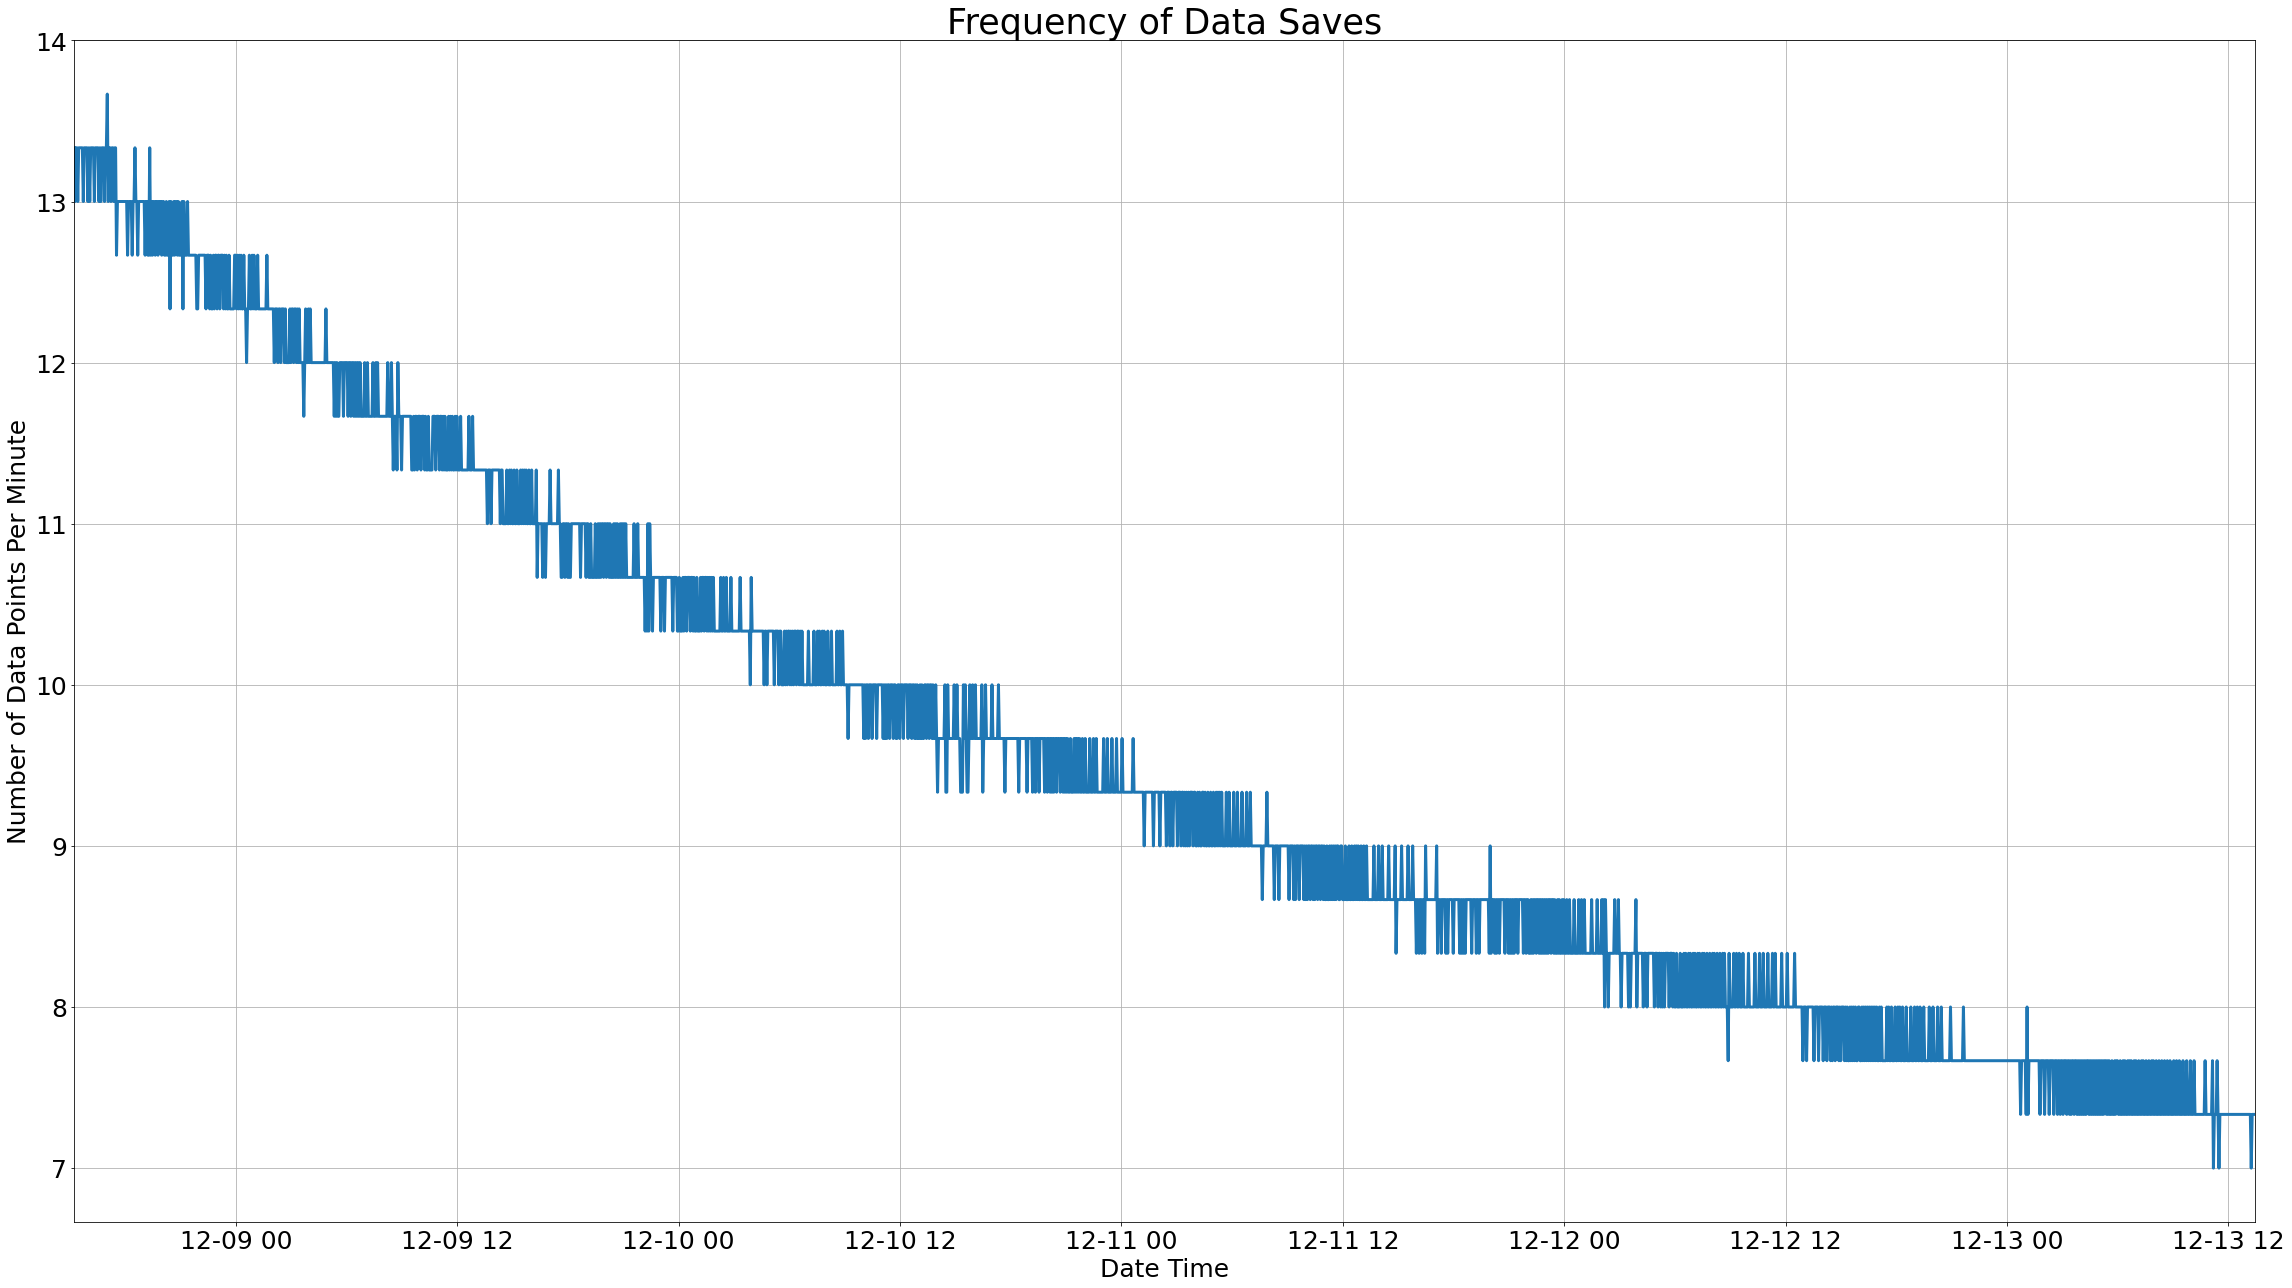

In [508]:
import matplotlib.pyplot as plt

fig_nPoints, ax = plt.subplots( 1, figsize = ( 32, 18 ) )
ax.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], [ crm[ nRow ][ -1 ] / ( binSize / 60 ) for nRow in range( 1, len( crm ) ) ], linewidth = 3 )
ax.set_xlim( crm[ 1 ][ 0 ], crm[ -1 ][ 0 ] )
ax.set_ylabel( "Number of Data Points Per Minute", fontsize = 25 )
ax.set_xlabel( "Date Time", fontsize = 25 )
ax.tick_params( axis = "both", labelsize = 25 )
ax.grid()
ax.set_title( "Frequency of Data Saves", fontsize = 35 )
fig_nPoints.set_facecolor( "white" )
fig_nPoints.tight_layout()

#=====SAVE PLOT INPUT=====#
savePlot = False
#=========================#

if savePlot: fig_nPoints.savefig( "Frequency of Data Saves.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )

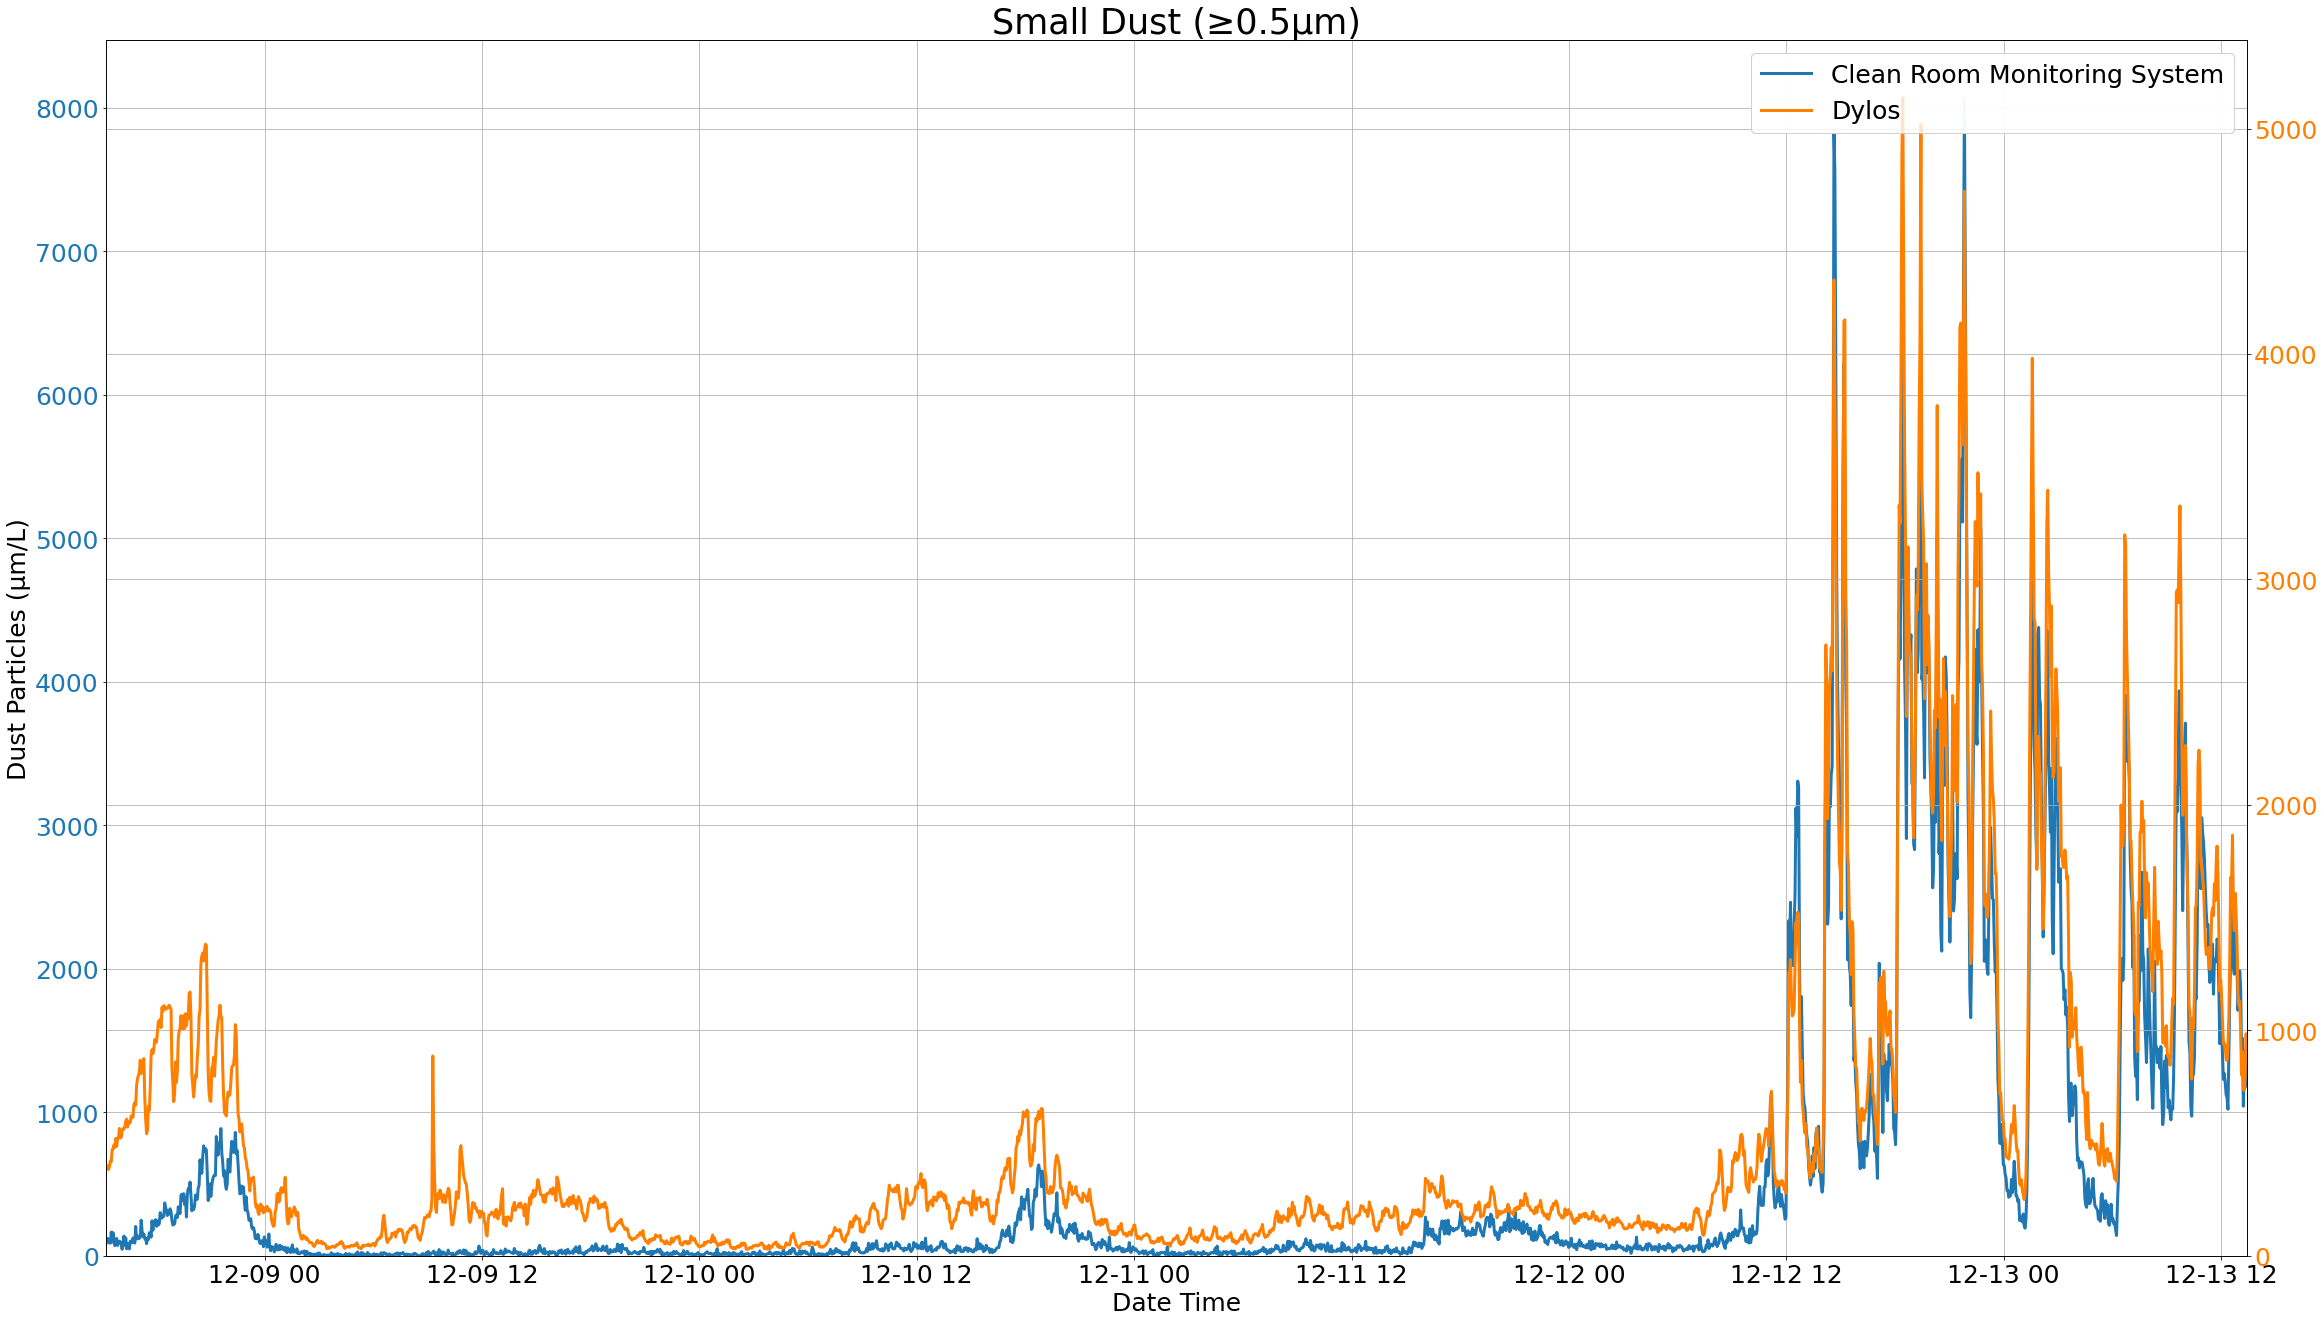

In [509]:
colors = [ "#1f77b4", "#FF7F00" ]
fig_small, ax_crm = plt.subplots( 1, figsize = ( 32, 18 ) )
ax_dc = ax_crm.twinx()
lines = []
axs = [ ax_crm, ax_dc ]
lines.append( ax_crm.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], [ crm[ nRow ][ 8 ] for nRow in range( 1, len( crm ) ) ], linewidth = 3, color = colors[ 0 ] ) )
lines.append( ax_dc.plot( [ dc[ nRow ][ 0 ] for nRow in range( 1, len( dc ) ) ], [ dc[ nRow ][ 1 ] for nRow in range( 1, len( dc ) ) ], linewidth = 3, color = colors[ 1 ] ) )

for nAx in range( len( axs ) ):
    axs[ nAx ].set_xlim( crm[ 1 ][ 0 ], crm[ -1 ][ 0 ] )
    axs[ nAx ].set_xlabel( "Date Time", fontsize = 25 )
    axs[ nAx ].tick_params( axis = "both", labelsize = 25 )
    axs[ nAx ].grid()
    axs[ nAx ].tick_params( axis = "y", labelsize = 25, labelcolor = colors[ nAx ] )
    axs[ nAx ].legend( lines[ 0 ] + lines[ 1 ], [ "Clean Room Monitoring System", "Dylos" ], loc = "upper right", fontsize = 25 )
    axs[ nAx ].set_ylim( 0 )
fig_small.set_facecolor( "white" )
fig_small.tight_layout()
ax_crm.set_title( "Small Dust (≥0.5" + u"\u03bcm)", fontsize = 35 )
ax_crm.set_ylabel( "Dust Particles (" + u"\u03bcm/L)", fontsize = 25 )

#=====SAVE PLOT INPUT=====#
savePlot = False
#=========================#

if savePlot: fig_small.savefig( "Small Dust.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )

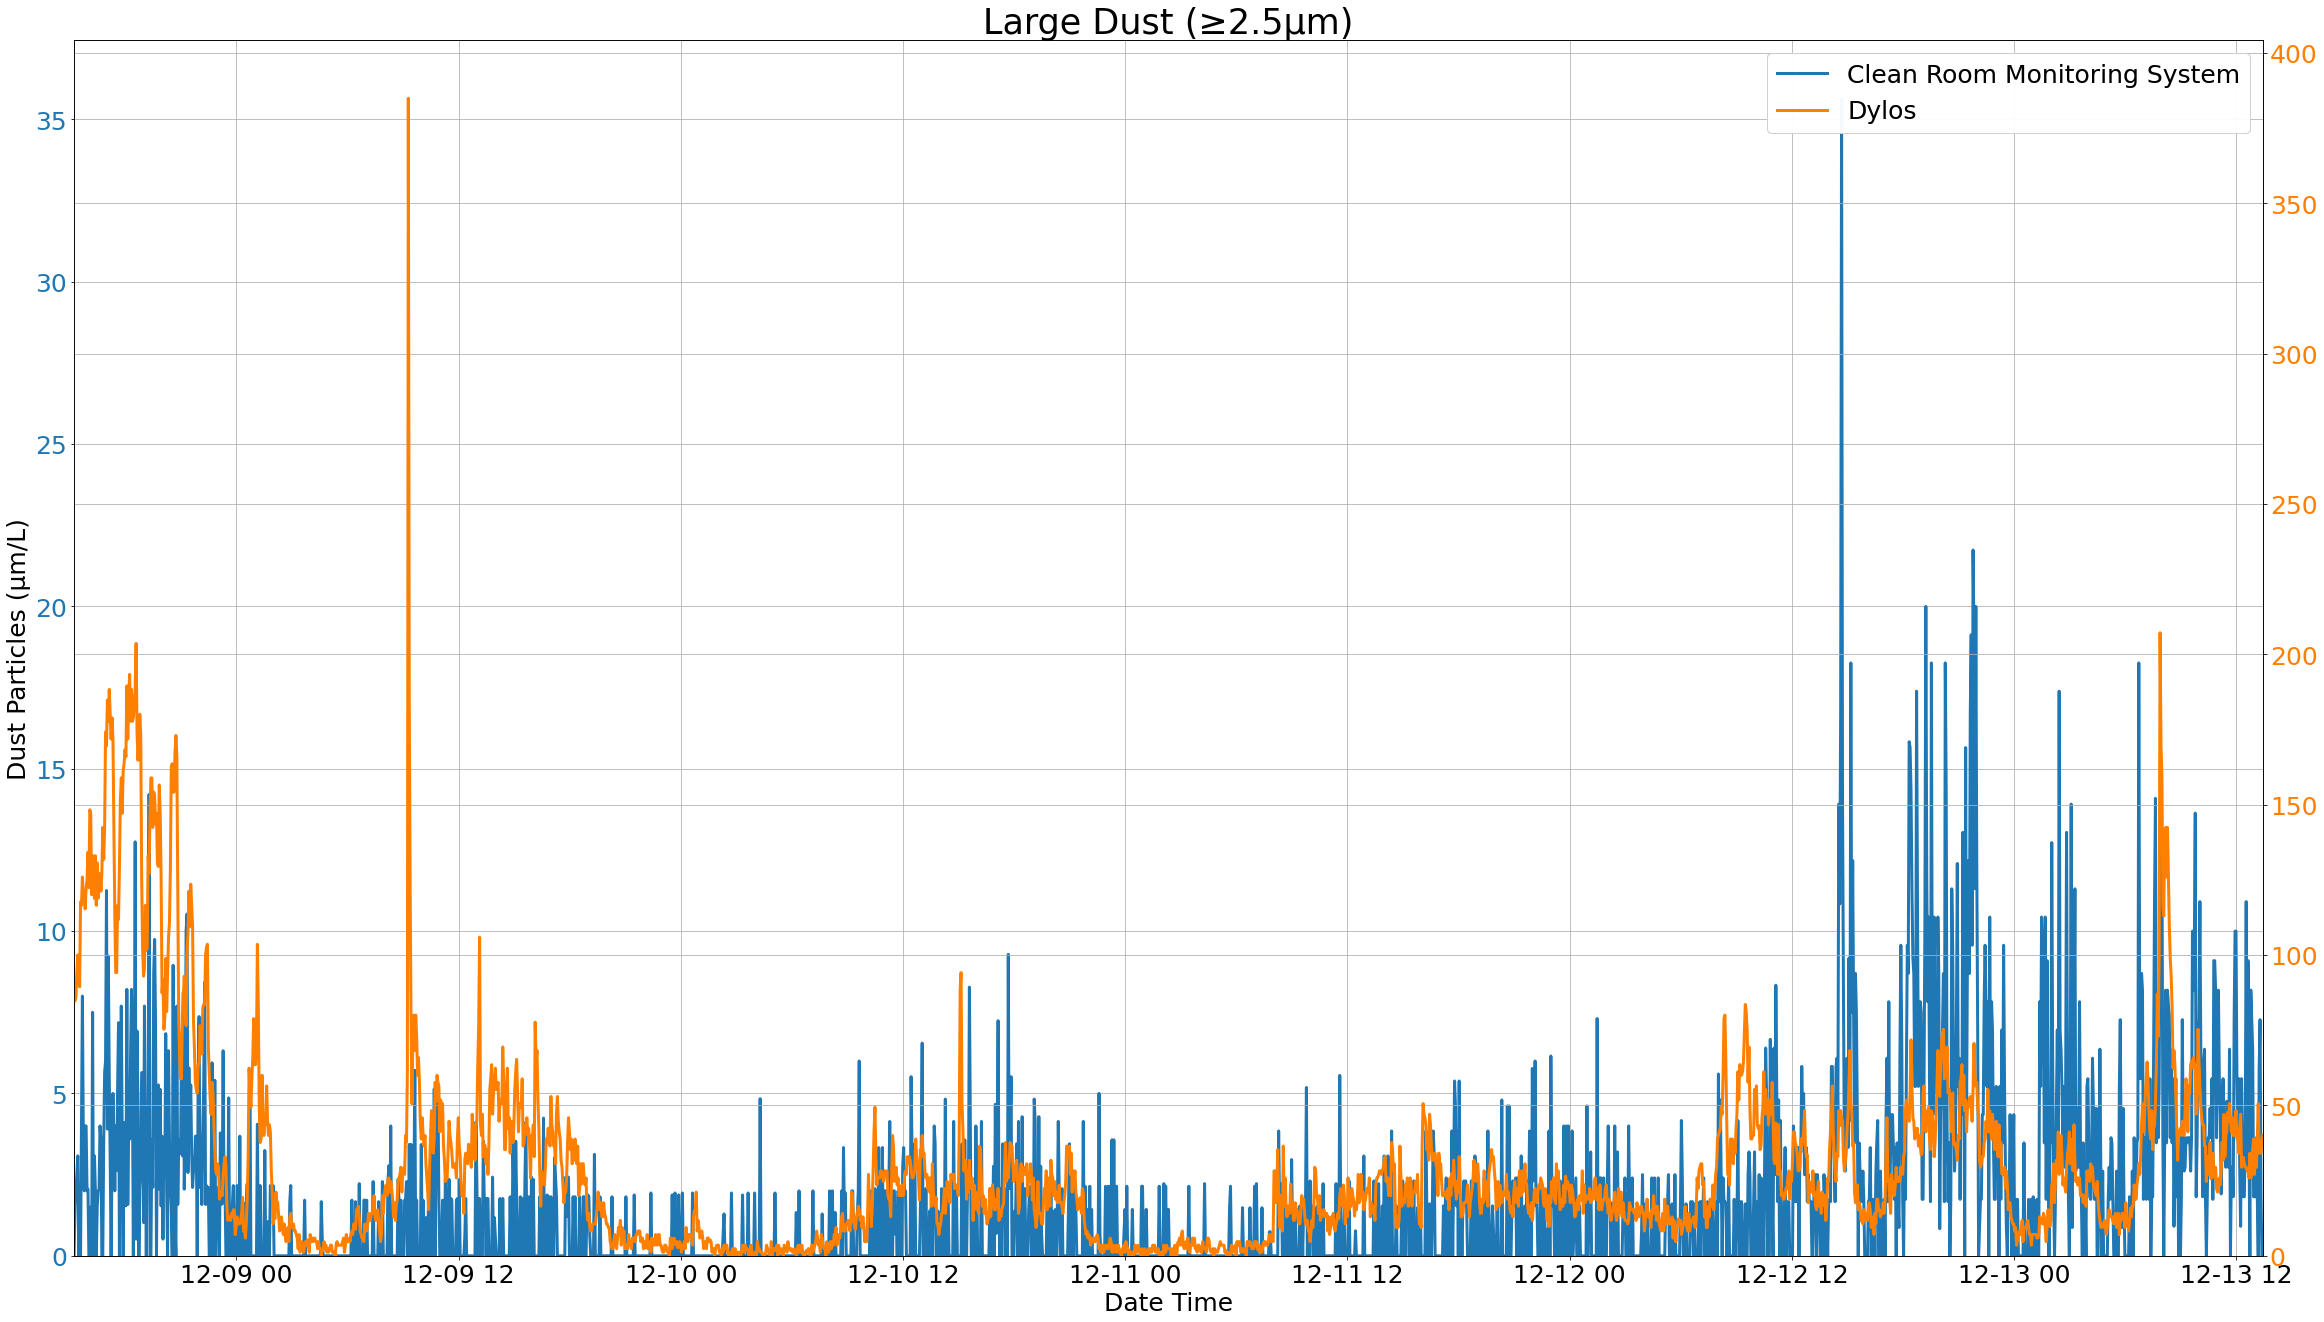

In [510]:
colors = [ "#1f77b4", "#FF7F00" ]
fig_large, ax_crm = plt.subplots( 1, figsize = ( 32, 18 ) )
ax_dc = ax_crm.twinx()
lines = []
axs = [ ax_crm, ax_dc ]
lines.append( ax_crm.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], [ crm[ nRow ][ 10 ] for nRow in range( 1, len( crm ) ) ], linewidth = 3, color = colors[ 0 ] ) )
lines.append( ax_dc.plot( [ dc[ nRow ][ 0 ] for nRow in range( 1, len( dc ) ) ], [ dc[ nRow ][ 2 ] for nRow in range( 1, len( dc ) ) ], linewidth = 3, color = colors[ 1 ] ) )

for nAx in range( len( axs ) ):
    axs[ nAx ].set_xlim( crm[ 1 ][ 0 ], crm[ -1 ][ 0 ] )
    axs[ nAx ].set_xlabel( "Date Time", fontsize = 25 )
    axs[ nAx ].tick_params( axis = "both", labelsize = 25 )
    axs[ nAx ].grid()
    axs[ nAx ].tick_params( axis = "y", labelsize = 25, labelcolor = colors[ nAx ] )
    axs[ nAx ].legend( lines[ 0 ] + lines[ 1 ], [ "Clean Room Monitoring System", "Dylos" ], loc = "upper right", fontsize = 25 )
    axs[ nAx ].set_ylim( 0 )
fig_large.set_facecolor( "white" )
fig_large.tight_layout()
ax_crm.set_title( "Large Dust (≥2.5" + u"\u03bcm)", fontsize = 35 )
ax_crm.set_ylabel( "Dust Particles (" + u"\u03bcm/L)", fontsize = 25 )

#=====SAVE PLOT INPUT=====#
savePlot = False
#=========================#

if savePlot: fig_large.savefig( "Large Dust.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )

Average: 4.8966303278976655


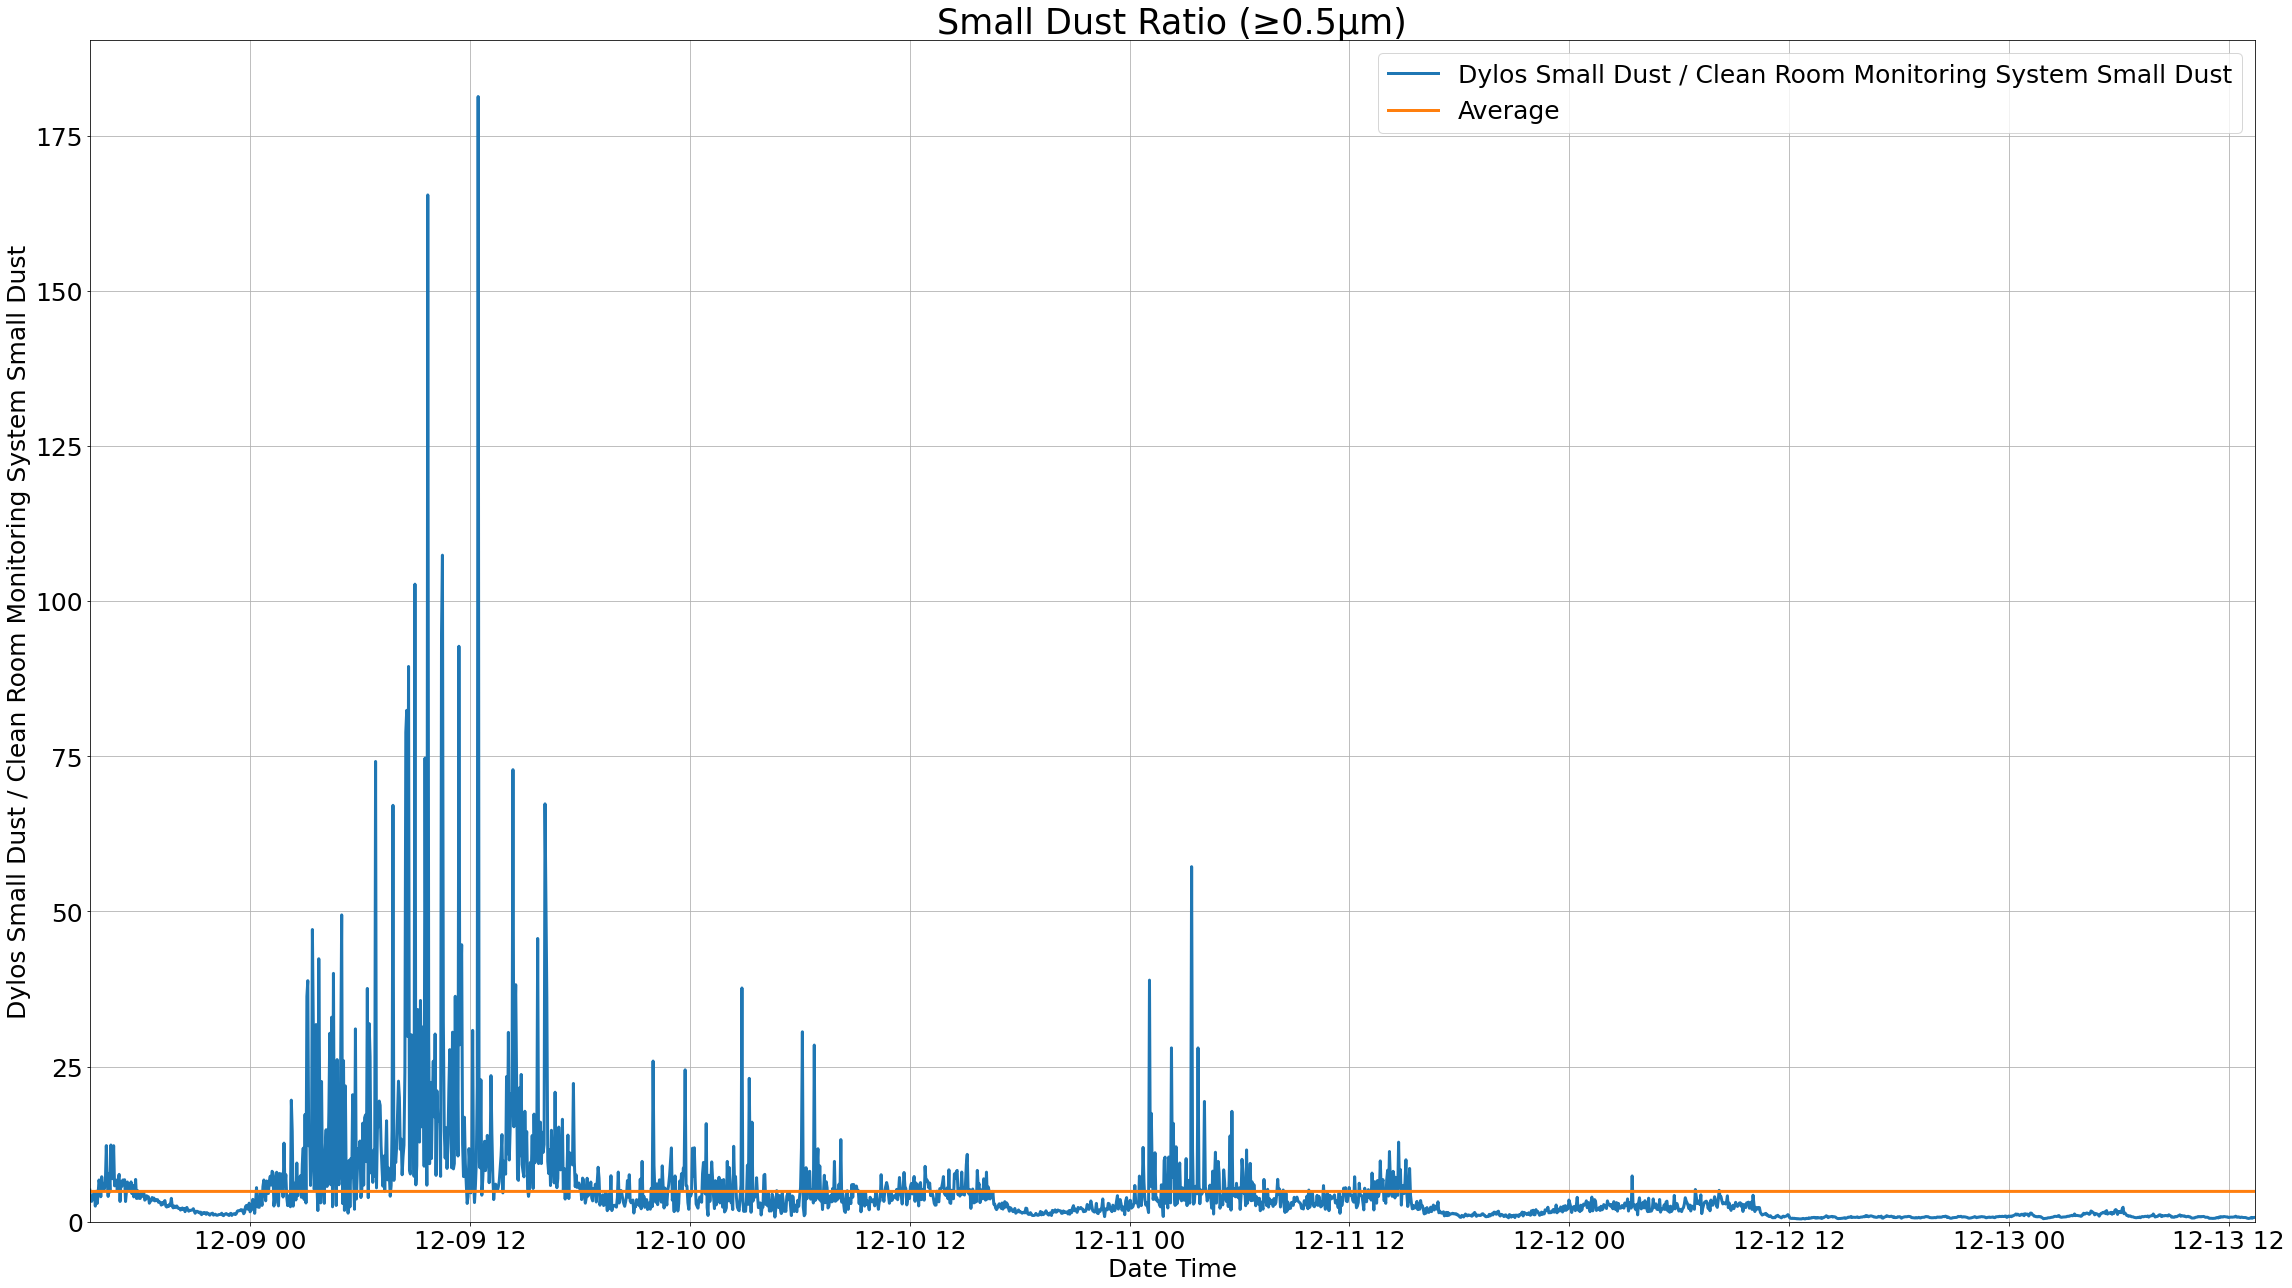

In [514]:
import matplotlib.pyplot as plt

ratio = []
for nRow in range( 1, len( crm ) ):
    if crm[ nRow ][ 8 ] != 0:
        ratio.append( dc[ nRow ][ 1 ] / crm[ nRow ][ 8 ] )
    else:
        ratio.append( dc[ nRow ][ 1 ] / 1 )

sum = 0
for data in ratio:
    sum += data
sum /= len( ratio )
avg = [ sum for n in ratio ]
print( "Average:", avg[ 0 ] )

fig_smallRatio, ax = plt.subplots( 1, figsize = ( 32, 18 ) )

ax.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], ratio, linewidth = 3, label = "Dylos Small Dust / Clean Room Monitoring System Small Dust" )
ax.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], avg, linewidth = 3, label = "Average" )

ax.set_xlim( crm[ 1 ][ 0 ], crm[ -1 ][ 0 ] )
ax.set_ylim( 0 )

ax.set_ylabel( "Dylos Small Dust / Clean Room Monitoring System Small Dust", fontsize = 25 )
ax.set_xlabel( "Date Time", fontsize = 25 )

ax.legend( loc = "upper right", fontsize = 25 )
ax.set_title( "Small Dust Ratio (≥0.5" + u"\u03bcm)", fontsize = 35 )

ax.tick_params( axis = "both", labelsize = 25 )
ax.grid()

fig_smallRatio.set_facecolor( "white" )
fig_smallRatio.tight_layout()

#=====SAVE PLOT INPUT=====#
savePlot = False
#=========================#

if savePlot: fig_smallRatio.savefig( "Small Dust Ratio.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )

Average: 17.345235635828264


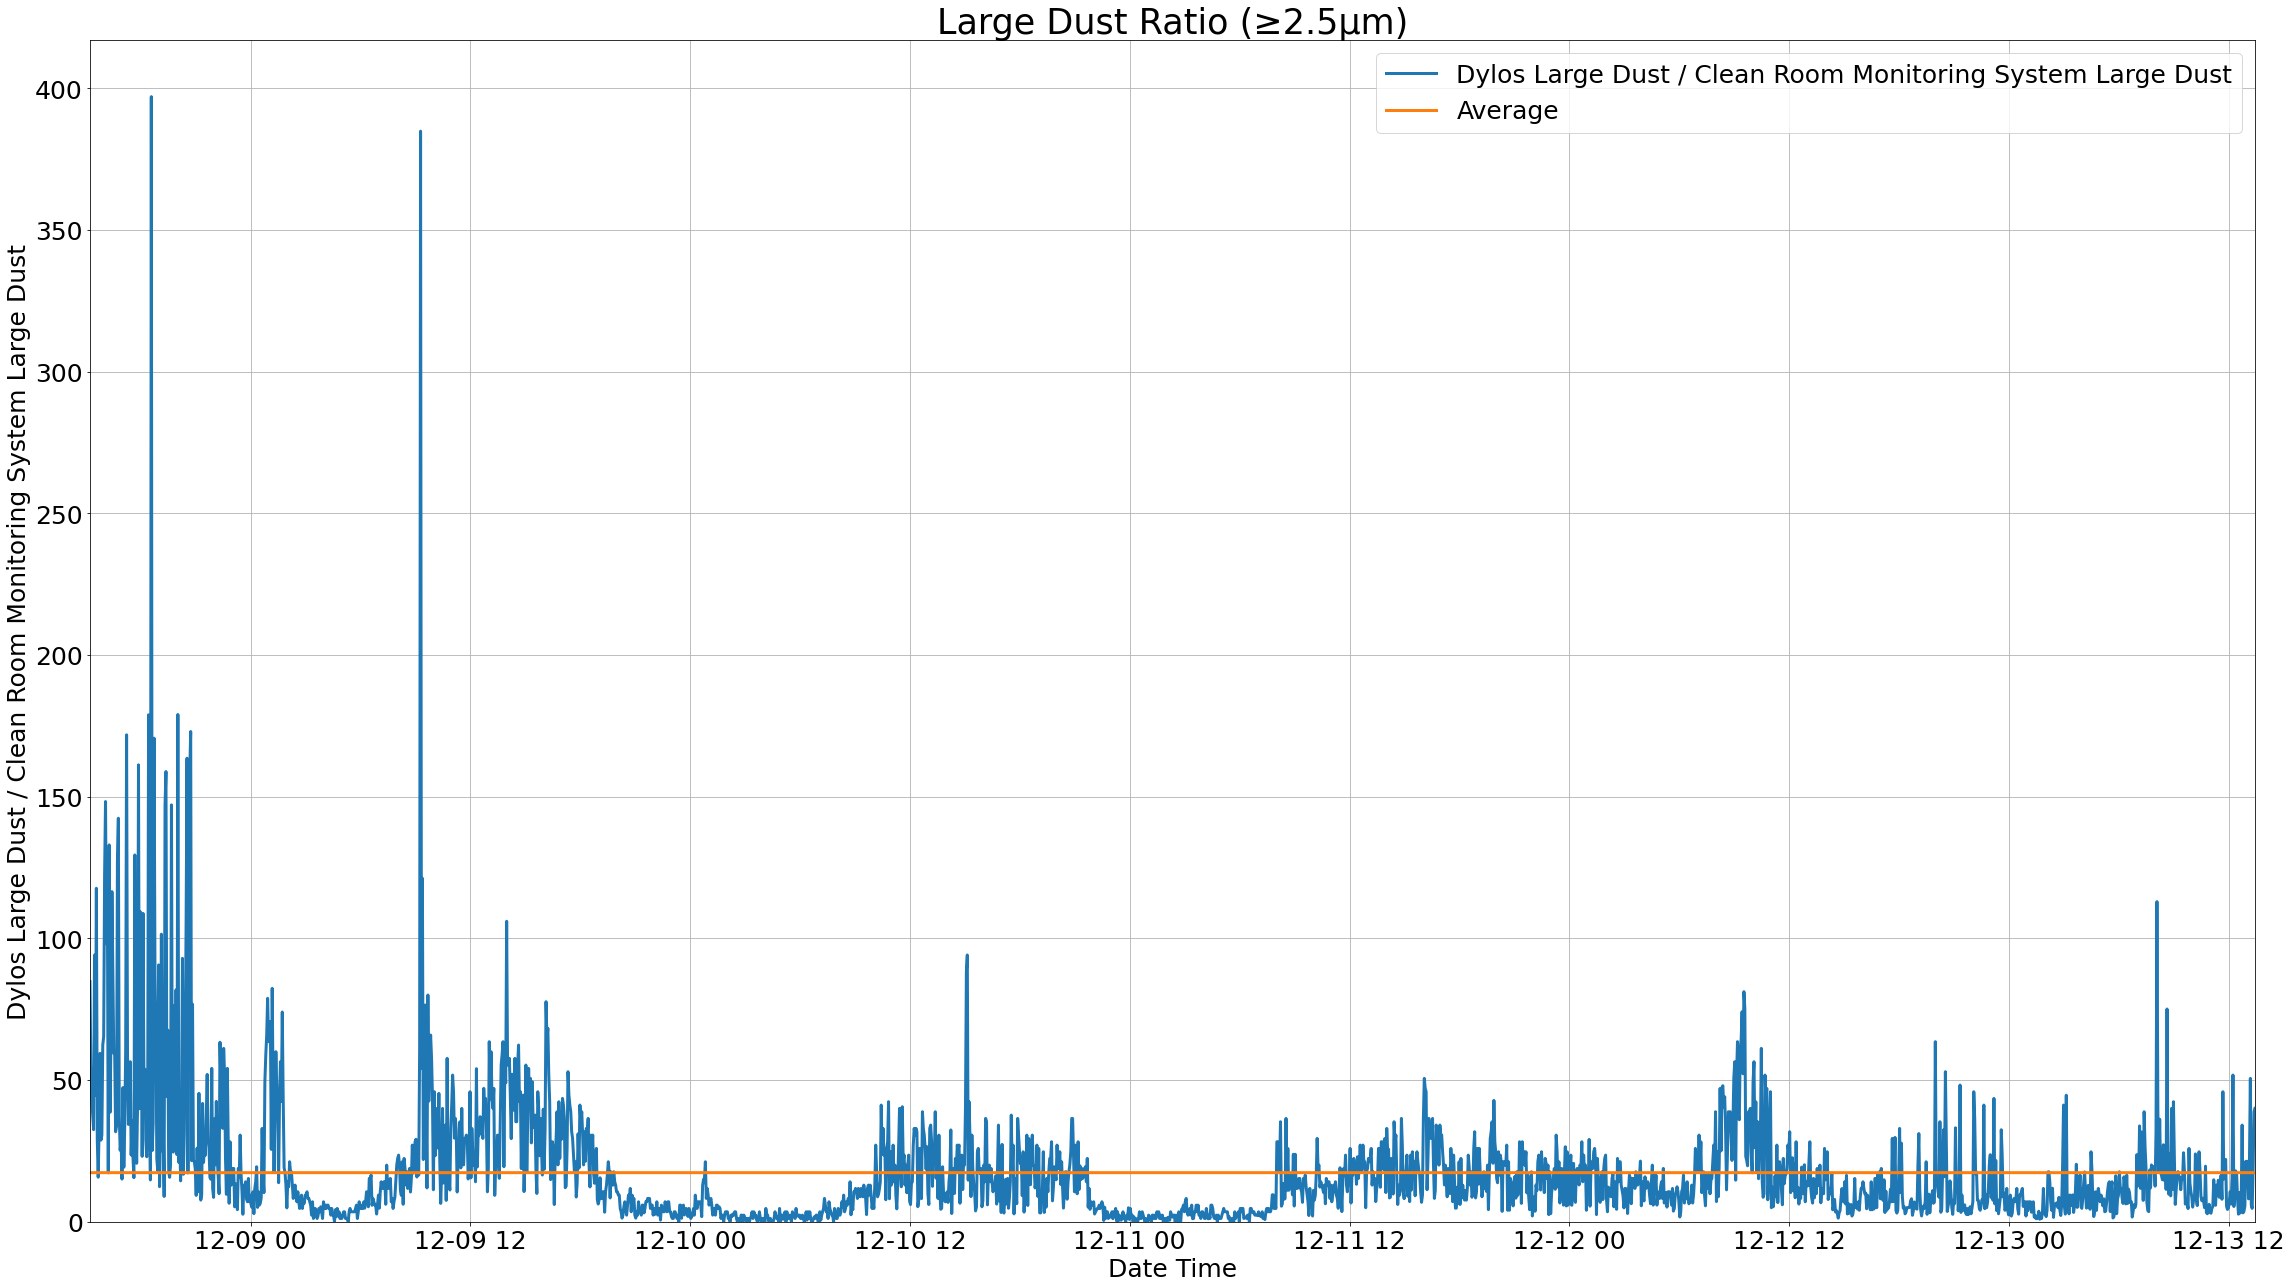

In [515]:
import matplotlib.pyplot as plt

ratio = []
for nRow in range( 1, len( crm ) ):
    if crm[ nRow ][ 10 ] != 0:
        ratio.append( dc[ nRow ][ 2 ] / crm[ nRow ][ 10 ] )
    else:
        ratio.append( dc[ nRow ][ 2 ] / 1 )

sum = 0
for data in ratio:
    sum += data
sum /= len( ratio )
avg = [ sum for n in ratio ]
print( "Average:", avg[ 0 ] )

fig_largeRatio, ax = plt.subplots( 1, figsize = ( 32, 18 ) )

ax.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], ratio, linewidth = 3, label = "Dylos Large Dust / Clean Room Monitoring System Large Dust" )
ax.plot( [ crm[ nRow ][ 0 ] for nRow in range( 1, len( crm ) ) ], avg, linewidth = 3, label = "Average" )

ax.set_xlim( crm[ 1 ][ 0 ], crm[ -1 ][ 0 ] )
ax.set_ylim( 0 )

ax.set_ylabel( "Dylos Large Dust / Clean Room Monitoring System Large Dust", fontsize = 25 )
ax.set_xlabel( "Date Time", fontsize = 25 )

ax.set_title( "Large Dust Ratio (≥2.5" + u"\u03bcm)", fontsize = 35 )
ax.legend( loc = "upper right", fontsize = 25 )

ax.tick_params( axis = "both", labelsize = 25 )
ax.grid()

fig_largeRatio.set_facecolor( "white" )
fig_largeRatio.tight_layout()

#=====SAVE PLOT INPUT=====#
savePlot = False
#=========================#

if savePlot: fig_largeRatio.savefig( "Large Dust Ratio.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )

In [516]:
#=====SAVE PLOT INPUT=====#
savePlot_nPoints = False
savePlot_small = False
savePlot_large = False
savePlot_smallRatio = False
savePlot_largeRatio = False
#=========================#
savePlot_all = False
#=========================#
intLabel = True
label = 7
#=========================#

if intLabel:
    if savePlot_nPoints or savePlot_all: fig_nPoints.savefig( "Data Points Per Minute " + "[" + str( label ) + "].png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_small or savePlot_all: fig_small.savefig( "Small Dust " + "[" + str( label ) + "].png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_large or savePlot_all: fig_large.savefig( "Large Dust " + "[" + str( label ) + "].png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_smallRatio or savePlot_all: fig_smallRatio.savefig( "Small Dust Ratio " + "[" + str( label ) + "].png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_largeRatio or savePlot_all: fig_largeRatio.savefig( "Large Dust Ratio " + "[" + str( label ) + "].png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
else:
    if savePlot_nPoints or savePlot_all: fig_nPoints.savefig( "Data Points Per Minute.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_small or savePlot_all: fig_small.savefig( "Small Dust.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_large or savePlot_all: fig_large.savefig( "Large Dust.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_smallRatio or savePlot_all: fig_smallRatio.savefig( "Small Dust Ratio.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )
    if savePlot_largeRatio or savePlot_all: fig_largeRatio.savefig( "Large Dust Ratio.png", facecolor = "w", transparent = False, format = "png", bbox_inches = "tight" )